<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/jax_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  
import jax
from jax.interpreters import xla
xla._xla_callable.cache_clear()

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# Import modules
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, device_put
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import minimize
from jax.ops import index, index_update

In [3]:
# Load data
data = np.load('spec4000error.npz')

# Standard PCA

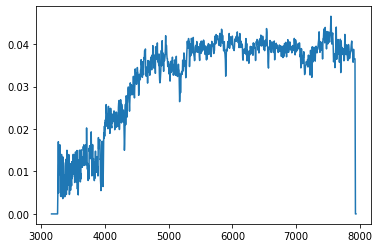

Number of capped errors 6756


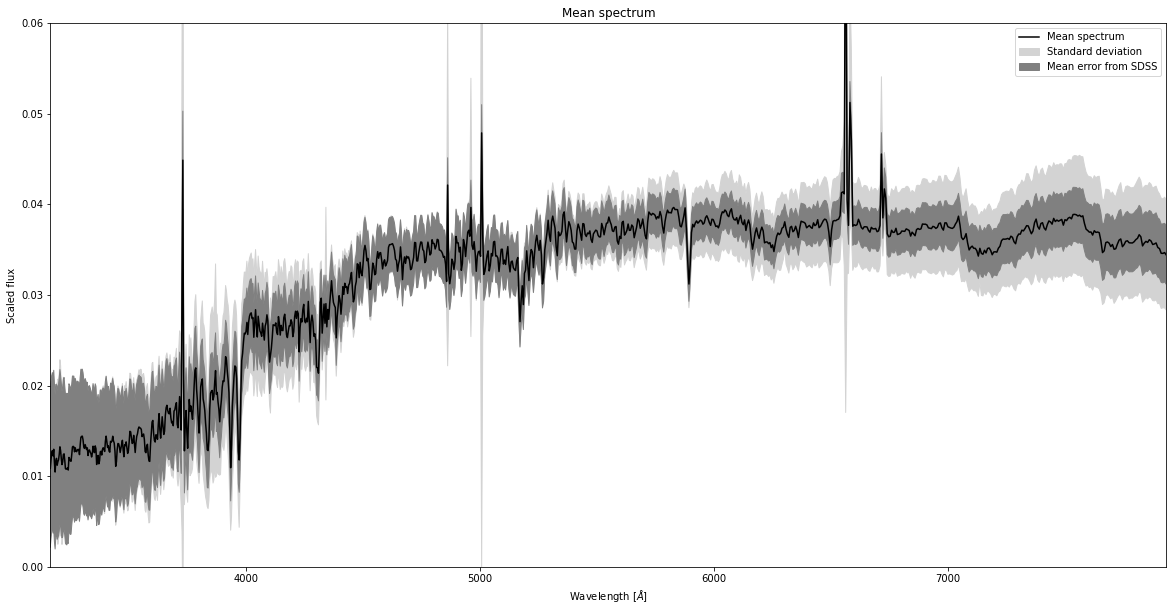

In [39]:
#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero and negative flux errors to NaN

zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
plt.figure()
plt.plot(wavelengths,X_normal[4])
plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

# %% Cap errors at a lower limit of 1e-5 times the flux
cap_counter = 0
for spectra in range(len(spec_err_norm)):
    for pixel in range(len(spec_err_norm[spectra])):
        if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-5 * X_normal[spectra][pixel]:
            spec_err_norm[spectra][pixel] = 1e-5 * X_normal[spectra][pixel]
            cap_counter += 1
print("Number of capped errors", cap_counter)

#%% Spectra errors with infs instead of nans
spec_err_norm_inf = np.nan_to_num(spec_err_norm,nan=np.inf)

#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

#%% Apply PCA
pca = PCA(n_components=4)
X_red = pca.fit_transform(X_norm_zeros)

#%% Fill spectra minus mean to be filled with zeros at nan values
X_mu = X_normal - mu
X_mu_zeros = np.nan_to_num(X_mu,nan=0.)

# Bayesian PCA

In [5]:
# Store W (have to transpose because pca.components_ has different dimensions to W in the equations)
W = pca.components_.T 

In [6]:
def sig_inv_diag_all(spec_err_norm_inf):
  sig_inv_diag_arr = spec_err_norm_inf ** (-2)
  log_sig = np.log(sig_inv_diag_arr)
  log_sig[log_sig == -np.inf] = 0.
  logdet_sig_arr = np.array([np.sum(i) for i in log_sig])
  return sig_inv_diag_arr, logdet_sig_arr

In [7]:
sig_inv_diag_arr, logdet_sig_arr = sig_inv_diag_all(spec_err_norm_inf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
ident = np.identity(W.shape[1])

def ln_onespec1(W, X_mu_zeros_n, sig_inv_diag, logdet_sig, ident):
  sig_inv = jnp.diagflat(sig_inv_diag)
  sig_inv_W = sig_inv_diag[:,None]*W
  #sig_inv_W = jnp.matmul(sig_inv,W)

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M, ident)
  C_inv = sig_inv -  jnp.matmul(sig_inv_W, jnp.matmul(M_inv, sig_inv_W.T))
  _, logdet_M = jnp.linalg.slogdet(M)

  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*jnp.matmul(X_mu_zeros_n.T,jnp.matmul(C_inv,X_mu_zeros_n))

  return l_n

def ln_onespec(W, X_mu_zeros_n, sig_inv_diag, logdet_sig, ident):
  sig_inv = jnp.diagflat(sig_inv_diag)
  sig_inv_W = sig_inv_diag[:,None]*W

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M,ident)
 
  W_sig = sig_inv_W.T  # = jnp.matmul(W.T,sig_inv) 
  W_sig_X = jnp.matmul(W_sig, X_mu_zeros_n)
  Minv_W_sig_X = jnp.matmul(M_inv, W_sig_X)
  Cinv_2 = jnp.matmul(sig_inv_W, Minv_W_sig_X)
  Cinv_1 = jnp.matmul(sig_inv, X_mu_zeros_n)
  Cinv_X = Cinv_1 - Cinv_2

  #C_inv = sig_inv -  jnp.matmul(sig_inv_W, jnp.matmul(M_inv, sig_inv_W.T))

  _, logdet_M = jnp.linalg.slogdet(M)

  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*jnp.matmul(X_mu_zeros_n.T, Cinv_X) #- 0.5*jnp.matmul(X_mu_zeros_n.T,jnp.matmul(C_inv,X_mu_zeros_n))

  return l_n


In [10]:
#@partial(jit, static_argnums=(1))
def ln_allspec(W, data1):
  X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr, ident = data1
  ln_total = 0
  for i in range(X_mu_zeros.shape[0]):
    ln_total += ln_onespec(W[0], X_mu_zeros[i], sig_inv_diag_arr[i], logdet_sig_arr[i], ident)
  return ln_total

In [58]:
# CHECK LN_TOTAL FOR ALL SPECTRA - same as next cell but using new C-1 order
ln_total = 0
for i in range(len(X_mu_zeros)):
  ln_total += ln_onespec(W, X_mu_zeros[i], sig_inv_diag_arr[i], logdet_sig_arr[i], ident)

ln_total

DeviceArray(-5.54262395e+11, dtype=float64)

In [ ]:
# CHECK LN_TOTAL FOR ALL SPECTRA
ln_total = 0
for i in range(len(X_mu_zeros)):
  ln_total += ln_onespec(W, X_mu_zeros[i], sig_inv_diag_arr[i], logdet_sig_arr[i], ident)

ln_total

DeviceArray(-6.05095653e+12, dtype=float64)

In [ ]:
from jax.experimental import optimizers
param_list = [1*W]
learning_rate = 1e-5
opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
opt_state = opt_init(param_list)

#@partial(jit, static_argnums=(2))
def update(step, opt_state, data1):
  params = get_params(opt_state)
  value, grads = jax.value_and_grad(ln_allspec)(params,data1)
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

num_iterations = 50

data1 = (X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr, ident)
for step in range(num_iterations):
  # Could potentially also iterate over batches of data
  loss_value, opt_state = update(step, opt_state, data1)

# optimised matrix:
#W_new_optimised = param_list[0]

W_new_optimised = get_params(opt_state)

In [61]:
print(W)
print(W_new_optimised[0])

[[ 0.0026315   0.02302108  0.00442197 -0.00635525]
 [ 0.00275812  0.02596745  0.00465351 -0.00696785]
 [ 0.00291665  0.02785674  0.00527495 -0.00748551]
 ...
 [-0.02643929 -0.14273106 -0.04825713  0.01841913]
 [-0.02639051 -0.14435834 -0.04803313  0.01410195]
 [-0.02531824 -0.1432185  -0.0486154   0.01278128]]
[[ 0.0026415   0.02301108  0.00441197 -0.00636525]
 [ 0.00276812  0.02597745  0.00466351 -0.00695785]
 [ 0.00290665  0.02786674  0.00528495 -0.00747551]
 ...
 [-0.02642929 -0.14274105 -0.04824713  0.01842913]
 [-0.02640051 -0.14436834 -0.04802313  0.01411195]
 [-0.02532824 -0.1432085  -0.04862539  0.01277128]]


In [ ]:
print(W)
print(W_new_optimised[0])

[[ 0.00263145  0.02302109  0.004422   -0.00635535]
 [ 0.00275808  0.02596738  0.0046536  -0.00696772]
 [ 0.00291661  0.02785674  0.00527488 -0.00748551]
 ...
 [-0.02643909 -0.14273104 -0.04825728  0.01841906]
 [-0.0263903  -0.1443583  -0.04803328  0.01410188]
 [-0.02531803 -0.14321847 -0.04861555  0.01278121]]
[[ 0.00259425  0.022362    0.00421429 -0.00689782]
 [ 0.0024434   0.02610995  0.00511188 -0.00671823]
 [ 0.0033121   0.02844741  0.0052329  -0.00690955]
 ...
 [-0.02584886 -0.14333393 -0.04776052  0.019027  ]
 [-0.02734966 -0.14490807 -0.04739982  0.01414673]
 [-0.02519236 -0.14269584 -0.04936755  0.0122503 ]]


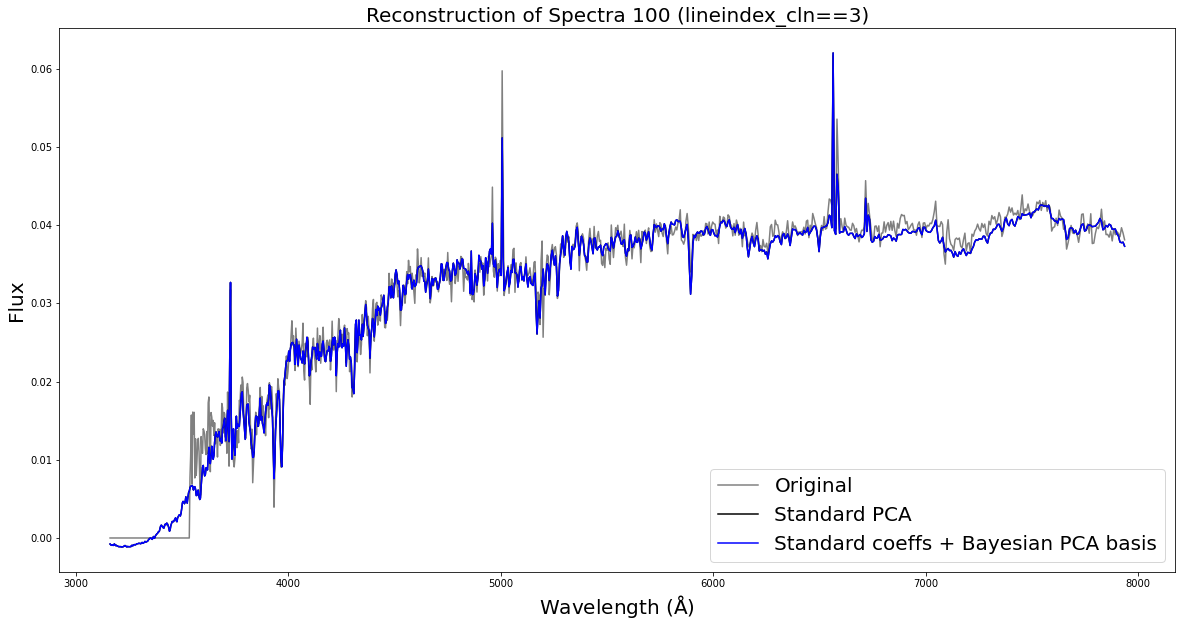

In [ ]:
spectra_num = 100
fig = plt.figure(figsize=(20,10))
plt.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], pca.components_), '-k', label='Standard PCA')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Bayesian coefficients

In [21]:
# Function to retrieve PCA coefficients from a PCA
def bayesian_coeffs(W, X_mu_zeros_n, sig_inv_diag, ident):
# y and yinvvvar are arrays of shape npix_y (one SED and its inverse variance vector)
# M_T is the transpose of the PCA components array, of shape (n_components, n_pix_y)
  #W_T = np.transpose(W)  # (n_pix_y, n_components) # trivial but I don't know if you work with M or M_T
  Myinv = W * sig_inv_diag[:, None]  # (n_pix_y, n_components)
  Hbar = np.matmul(W.T, Myinv) + ident #  (n_components, n_components)
  etabar = np.sum(Myinv * X_mu_zeros_n[:, None], axis=0)  # (n_components)
  theta_map = np.linalg.solve(Hbar, etabar) # result: maximum a posteriori
  return theta_map

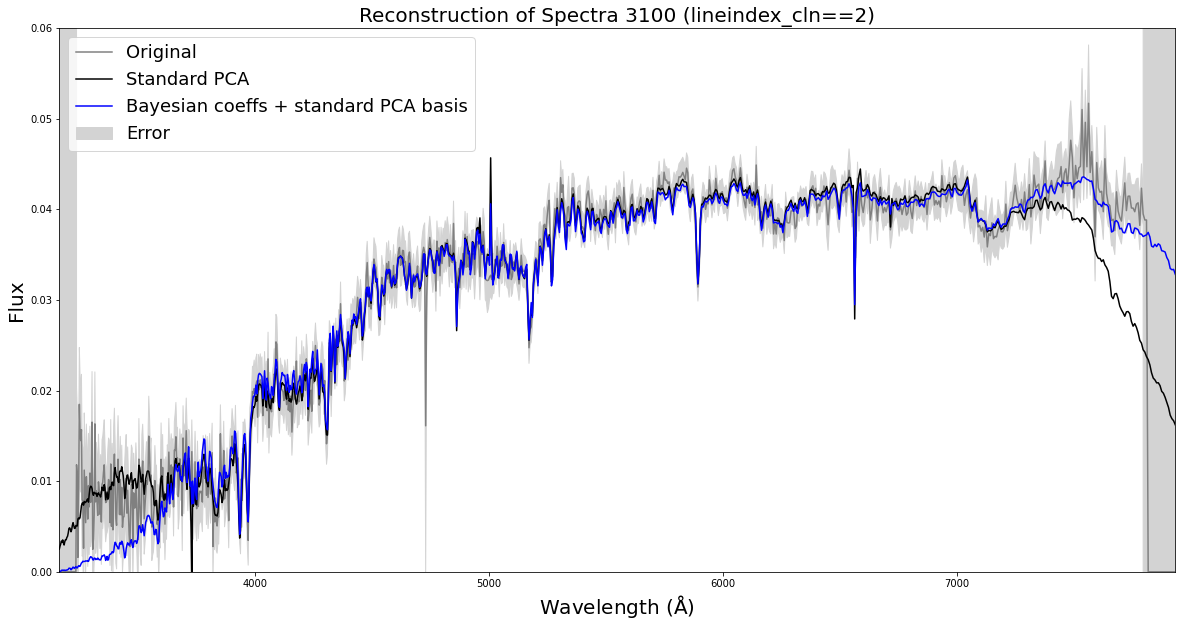

In [53]:
spec_num = 3100
fig = plt.figure(figsize=(20,10))

plt.plot(wavelengths, X_norm_zeros[spec_num], '-', c='gray', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], pca.components_), '-k', label='Standard PCA')
plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num], ident), W.T), '-b', label='Bayesian coeffs + standard PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num]), W_new_optimised[0].T), '-g', label='Bayesian coeffs + Bayesian PCA basis')

spec_err_norm_large = np.copy(spec_err_norm_inf)
spec_err_norm_large[spec_err_norm_large==np.inf] = 10
plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_large[spec_num], X_norm_zeros[spec_num] + spec_err_norm_large[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_large[spec_num], color='orange', label='Error')
#plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_inf[spec_num], X_norm_zeros[spec_num] + spec_err_norm_inf[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_inf[spec_num], color='orange', label='Error')
plt.ylim(0,0.06)
plt.xlim(wavelengths[0],wavelengths[-1])

plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spec_num} (lineindex_cln=={subclass[spec_num]})', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [ ]:
np.save('W_new_optimised_10iter_1e-4lr.npy', np.asarray(W_new_optimised[0]))